In [143]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import OneCycleLR #ExponentialLR
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

## Prepare data

In [ ]:
# Victoria
# Visit: https://www.covid19data.com.au/victoria
# Scroll to "Local active cases"
# Click download data
# Upload to $HOME/.fastai/data/covid/victoria.csv

In [2]:
def load_cases():
    cases = []
    with open('/home/rohan/.fastai/data/covid/victoria.csv') as file:
        reader = csv.DictReader(file, delimiter=',')
        for row in reader:
            cases.append(int(row['All active cases']))
    return cases

In [3]:
def calc_running_mean(x, window):
    # https://stackoverflow.com/a/22621523
    return np.convolve(x, np.ones(window) / window, mode='valid')

In [4]:
def normalise(x, m, s): return (x - m) / s

In [5]:
def normalise_data(x, mean, std):
    return [normalise(n, mean, std) for n in x]

In [6]:
def build_training_data(input_window, output_window):
    window = input_window + output_window
    x = []
    y = []
    for i in range(len(running_mean) - window):
        x.append(norm_running_mean[i:i+input_window])
        y.append(norm_running_mean[i+input_window:i+window])
    return x, y

In [7]:
def split_data(x, y, split):
    train_len = int(len(x) * train_valid_split)
    x_train = torch.tensor(x[:train_len]).float()
    y_train = torch.tensor(y[:train_len]).float()
    x_valid = torch.tensor(x[train_len:]).float()
    y_valid = torch.tensor(y[train_len:]).float()
    return x_train, y_train, x_valid, y_valid

In [8]:
running_mean_window = 7
input_window = 30
output_window = 30
train_valid_split = 0.8

In [9]:
cases = load_cases()
running_mean = calc_running_mean(cases, running_mean_window)
mean, std = np.mean(running_mean), np.std(running_mean)
norm_running_mean = normalise_data(running_mean, mean, std)
x, y = build_training_data(input_window, output_window)
x_train, y_train, x_valid, y_valid = split_data(x, y, train_valid_split)

## Define model

In [10]:
num_inputs = input_window
num_hidden = 200
num_outputs = output_window
learning_rate = 0.01

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [12]:
def prep_conv(x): return x.unsqueeze(dim=1)

In [13]:
def flatten(x): return x.view(x.shape[0], -1)

In [14]:
def get_model(layers, learning_rate):
    model = nn.Sequential(*layers)
    return model, optim.SGD(model.parameters(), lr=learning_rate)

## Training

In [15]:
batch_size = 64

In [16]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [17]:
def accuracy(out, yb):
    return 1 / (out - yb).abs().sum()

In [166]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    losses, accuracies, lrs = [], [], []
    scheduler = OneCycleLR(opt, 0.01, total_steps=epochs, steps_per_epoch=1)
    for epoch in range(epochs):
        # Train
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        # Evaluate
        model.eval()
        with torch.no_grad():
            total_loss, total_acc = 0.,0.
            for xb, yb in valid_dl:
                pred = model(xb)
                total_loss += loss_func(pred, yb)
                total_acc  += accuracy(pred, yb)
        nv = len(valid_dl)
        losses.append(total_loss/nv)
        accuracies.append(total_acc/nv)
        lrs.append(scheduler.get_last_lr())
        
        # Print
        if epoch % 100 == 0:
            print(epoch, total_loss/nv, total_acc/nv)
        scheduler.step()
            
    # Plot losses and accuracies
    print(epochs, total_loss/nv, total_acc/nv)
    plt.plot(losses)
    plt.plot(torch.tensor(accuracies)*100)
    #plt.plot(lrs)
    plt.show()
    return total_loss/nv, total_acc/nv

In [19]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False)

In [21]:
loss_func = torch.nn.MSELoss()

In [22]:
def print_shape(x): print(x.shape); return x

In [169]:
model, opt = get_model([
    Lambda(prep_conv),

    nn.Conv1d(1, 4, 3, padding=1), nn.ReLU(),
    nn.Conv1d(4, 8, 3, padding=1), nn.ReLU(),
    nn.Conv1d(8, 16, 3, padding=1), nn.ReLU(),

    nn.Conv1d(16, 16, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv1d(16, 16, 3, padding=1, stride=2), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(128, 30),
    #Lambda(print_shape), 
], learning_rate=0.01)

0 tensor(0.1271) tensor(0.0025)
100 tensor(0.0662) tensor(0.0038)
200 tensor(0.0436) tensor(0.0066)
300 tensor(0.0279) tensor(0.0092)
400 tensor(0.0603) tensor(0.0064)
500 tensor(0.0622) tensor(0.0064)


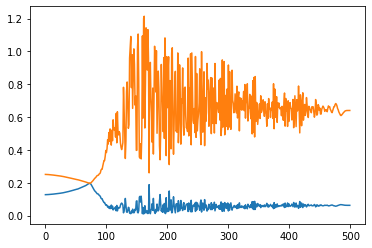

In [170]:
loss, acc = fit(500, model, loss_func, opt, train_dl, valid_dl)

## Train and visualise

In [25]:
def plot_results(y):
    plt.figure(figsize=(24, 12), dpi=80)
    for i in range(y.shape[0]):
        plt.plot(range(i+input_window, i+input_window+output_window), y[i].tolist())
    plt.plot(running_mean)
    plt.show()

In [191]:
def train_and_visualise(layers, epochs=1000):
    model, opt = get_model(layers, learning_rate=0.01)
    loss, acc = fit(epochs, model, loss_func, opt, train_dl, valid_dl)
    preds = model(torch.tensor(x).float())
    unnorm_preds = preds * std + mean
    plot_results(unnorm_preds)
    return model

0 tensor(0.1167) tensor(0.0026)
100 tensor(0.0259) tensor(0.0069)
200 tensor(0.0379) tensor(0.0082)
300 tensor(0.2263) tensor(0.0028)
400 tensor(0.0769) tensor(0.0079)
500 tensor(0.0768) tensor(0.0072)
600 tensor(0.1424) tensor(0.0066)
700 tensor(0.1349) tensor(0.0070)
800 tensor(0.1616) tensor(0.0063)
900 tensor(0.1568) tensor(0.0065)
1000 tensor(0.1552) tensor(0.0065)


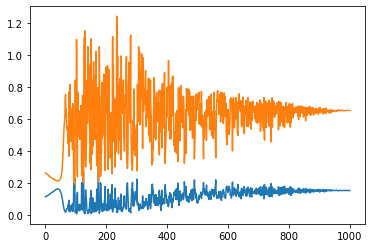

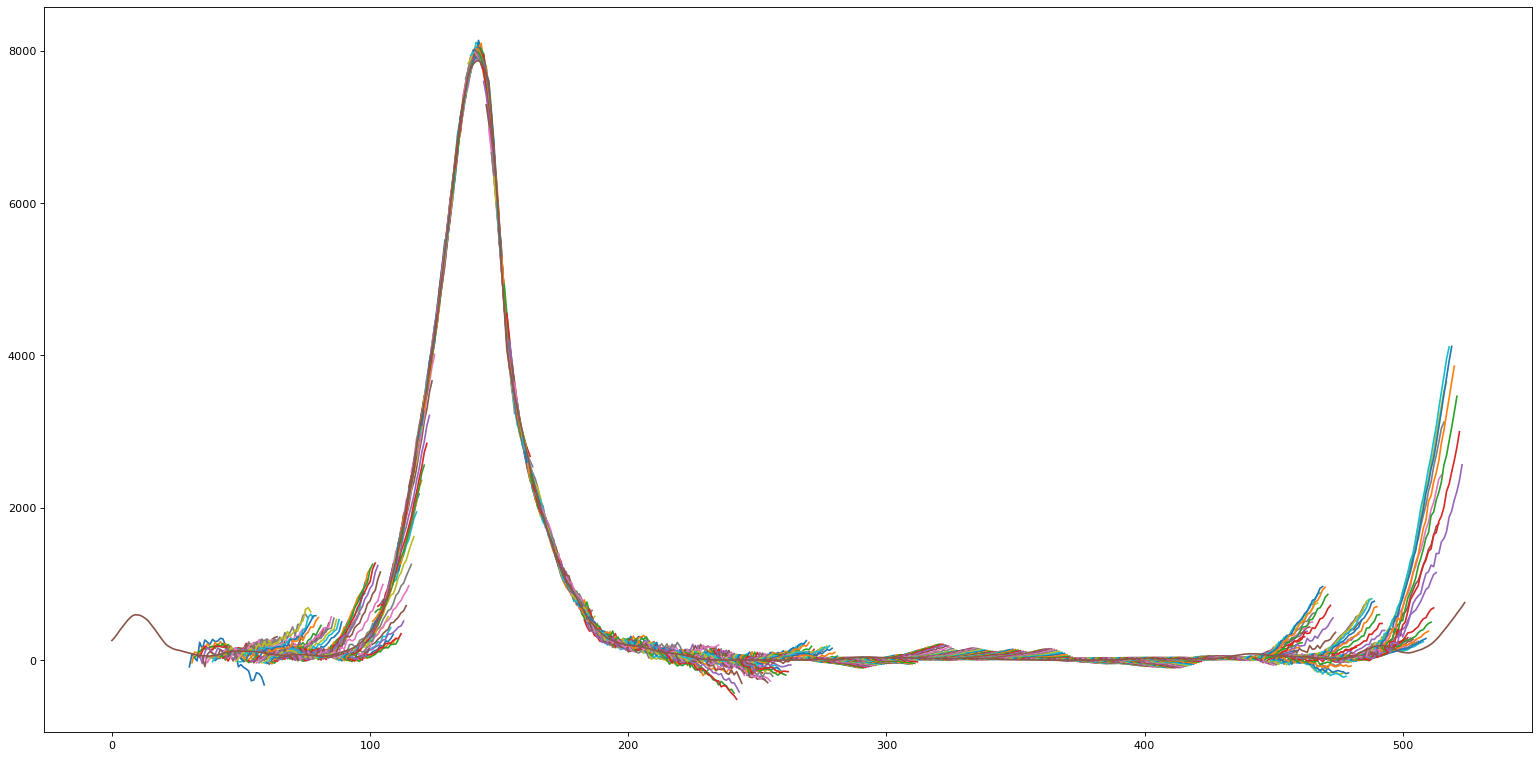

In [164]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1, 4, 3, padding=1), nn.ReLU(),
    nn.Conv1d(4, 8, 3, padding=1), nn.ReLU(),
    nn.Conv1d(8, 16, 3, padding=1), nn.ReLU(),

    nn.Conv1d(16, 16, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv1d(16, 16, 3, padding=1, stride=2), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(128, 30),
])

0 tensor(0.1178) tensor(0.0026)
100 tensor(0.0649) tensor(0.0058)
200 tensor(0.0641) tensor(0.0071)
300 tensor(0.0746) tensor(0.0068)
400 tensor(0.1014) tensor(0.0064)
500 tensor(0.1316) tensor(0.0054)
600 tensor(0.1089) tensor(0.0061)
700 tensor(0.1334) tensor(0.0051)
800 tensor(0.1237) tensor(0.0054)
900 tensor(0.1279) tensor(0.0052)
1000 tensor(0.1221) tensor(0.0054)


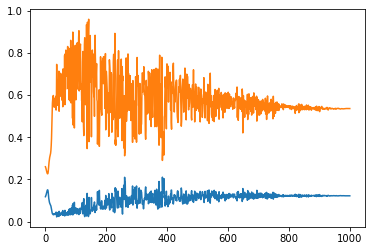

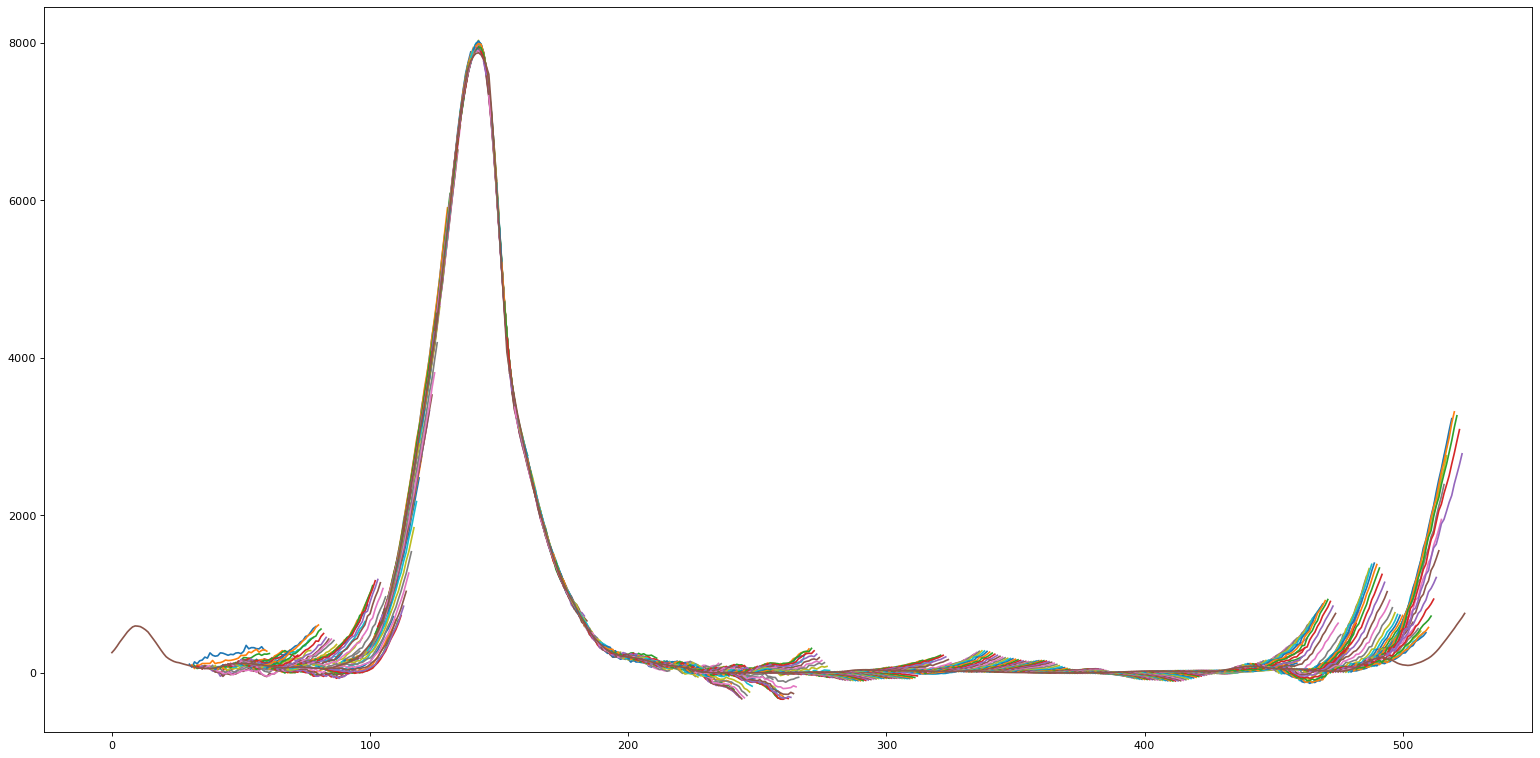

In [165]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1, 32, 3, padding=1), nn.ReLU(),
    nn.Conv1d(32, 32, 3, padding=1), nn.ReLU(),
    nn.Conv1d(32, 32, 3, padding=1), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
])

0 tensor(0.1278) tensor(0.0025)
100 tensor(0.0268) tensor(0.0066)
200 tensor(0.0368) tensor(0.0063)
300 tensor(0.0456) tensor(0.0061)
400 tensor(0.0436) tensor(0.0068)
500 tensor(0.0497) tensor(0.0066)


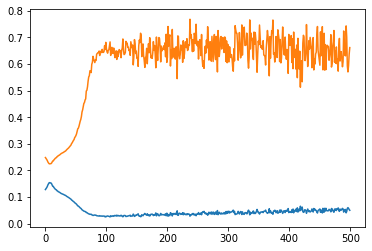

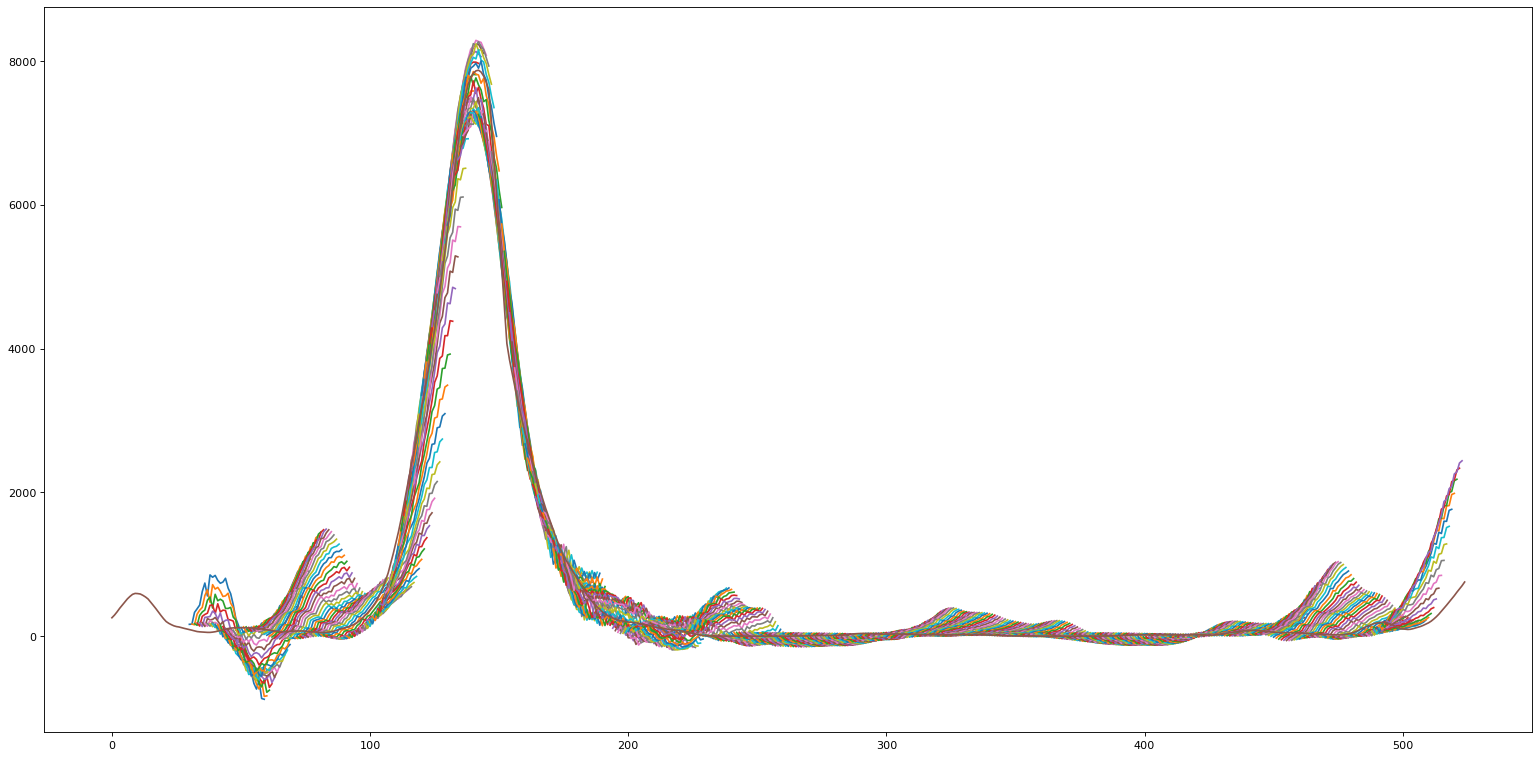

In [109]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1, 32, 5, padding=2), nn.ReLU(),
    nn.Conv1d(32, 32, 5, padding=2), nn.ReLU(),
    nn.Conv1d(32, 32, 5, padding=2), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
])

0 tensor(0.1193) tensor(0.0026)
100 tensor(0.0246) tensor(0.0071)
200 tensor(0.0163) tensor(0.0086)
300 tensor(0.0261) tensor(0.0080)
400 tensor(0.0373) tensor(0.0070)
500 tensor(0.0373) tensor(0.0073)
600 tensor(0.0457) tensor(0.0065)
700 tensor(0.0489) tensor(0.0064)
800 tensor(0.0465) tensor(0.0070)
900 tensor(0.0453) tensor(0.0075)
1000 tensor(0.0501) tensor(0.0071)


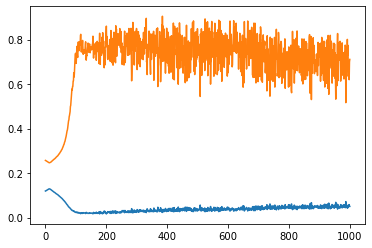

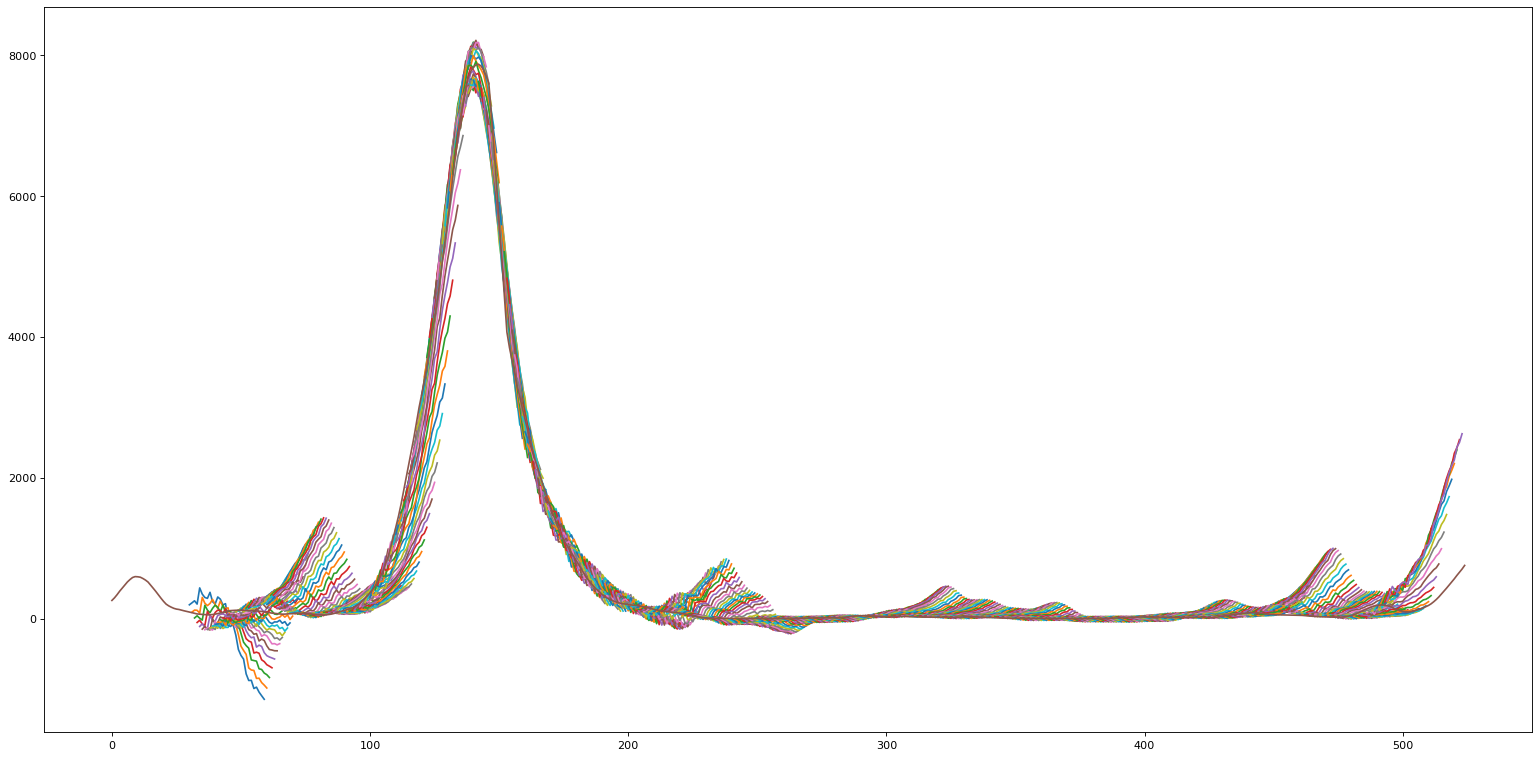

In [116]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1, 32, 11, padding=5), nn.ReLU(),
    nn.Conv1d(32, 32, 11, padding=5), nn.ReLU(),
    nn.Conv1d(32, 32, 11, padding=5), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
])

Adjusting learning rate of group 0 to 5.0000e-03.
0 tensor(0.1186) tensor(0.0026)
Adjusting learning rate of group 0 to 4.9950e-03.
Adjusting learning rate of group 0 to 4.9900e-03.
Adjusting learning rate of group 0 to 4.9850e-03.
Adjusting learning rate of group 0 to 4.9800e-03.
Adjusting learning rate of group 0 to 4.9750e-03.
Adjusting learning rate of group 0 to 4.9701e-03.
Adjusting learning rate of group 0 to 4.9651e-03.
Adjusting learning rate of group 0 to 4.9601e-03.
Adjusting learning rate of group 0 to 4.9552e-03.
Adjusting learning rate of group 0 to 4.9502e-03.
Adjusting learning rate of group 0 to 4.9453e-03.
Adjusting learning rate of group 0 to 4.9403e-03.
Adjusting learning rate of group 0 to 4.9354e-03.
Adjusting learning rate of group 0 to 4.9305e-03.
Adjusting learning rate of group 0 to 4.9255e-03.
Adjusting learning rate of group 0 to 4.9206e-03.
Adjusting learning rate of group 0 to 4.9157e-03.
Adjusting learning rate of group 0 to 4.9108e-03.
Adjusting learning

Adjusting learning rate of group 0 to 4.2222e-03.
Adjusting learning rate of group 0 to 4.2180e-03.
Adjusting learning rate of group 0 to 4.2137e-03.
Adjusting learning rate of group 0 to 4.2095e-03.
Adjusting learning rate of group 0 to 4.2053e-03.
Adjusting learning rate of group 0 to 4.2011e-03.
Adjusting learning rate of group 0 to 4.1969e-03.
Adjusting learning rate of group 0 to 4.1927e-03.
Adjusting learning rate of group 0 to 4.1885e-03.
Adjusting learning rate of group 0 to 4.1843e-03.
Adjusting learning rate of group 0 to 4.1802e-03.
Adjusting learning rate of group 0 to 4.1760e-03.
Adjusting learning rate of group 0 to 4.1718e-03.
Adjusting learning rate of group 0 to 4.1676e-03.
Adjusting learning rate of group 0 to 4.1635e-03.
Adjusting learning rate of group 0 to 4.1593e-03.
Adjusting learning rate of group 0 to 4.1551e-03.
Adjusting learning rate of group 0 to 4.1510e-03.
Adjusting learning rate of group 0 to 4.1468e-03.
Adjusting learning rate of group 0 to 4.1427e-03.


Adjusting learning rate of group 0 to 3.5618e-03.
Adjusting learning rate of group 0 to 3.5582e-03.
Adjusting learning rate of group 0 to 3.5547e-03.
Adjusting learning rate of group 0 to 3.5511e-03.
Adjusting learning rate of group 0 to 3.5476e-03.
Adjusting learning rate of group 0 to 3.5440e-03.
Adjusting learning rate of group 0 to 3.5405e-03.
Adjusting learning rate of group 0 to 3.5370e-03.
Adjusting learning rate of group 0 to 3.5334e-03.
Adjusting learning rate of group 0 to 3.5299e-03.
Adjusting learning rate of group 0 to 3.5263e-03.
Adjusting learning rate of group 0 to 3.5228e-03.
Adjusting learning rate of group 0 to 3.5193e-03.
Adjusting learning rate of group 0 to 3.5158e-03.
Adjusting learning rate of group 0 to 3.5123e-03.
Adjusting learning rate of group 0 to 3.5088e-03.
Adjusting learning rate of group 0 to 3.5052e-03.
Adjusting learning rate of group 0 to 3.5017e-03.
Adjusting learning rate of group 0 to 3.4982e-03.
Adjusting learning rate of group 0 to 3.4947e-03.


Adjusting learning rate of group 0 to 3.0198e-03.
Adjusting learning rate of group 0 to 3.0168e-03.
Adjusting learning rate of group 0 to 3.0137e-03.
Adjusting learning rate of group 0 to 3.0107e-03.
Adjusting learning rate of group 0 to 3.0077e-03.
Adjusting learning rate of group 0 to 3.0047e-03.
Adjusting learning rate of group 0 to 3.0017e-03.
Adjusting learning rate of group 0 to 2.9987e-03.
Adjusting learning rate of group 0 to 2.9957e-03.
Adjusting learning rate of group 0 to 2.9927e-03.
Adjusting learning rate of group 0 to 2.9897e-03.
Adjusting learning rate of group 0 to 2.9867e-03.
Adjusting learning rate of group 0 to 2.9837e-03.
Adjusting learning rate of group 0 to 2.9808e-03.
Adjusting learning rate of group 0 to 2.9778e-03.
Adjusting learning rate of group 0 to 2.9748e-03.
Adjusting learning rate of group 0 to 2.9718e-03.
Adjusting learning rate of group 0 to 2.9689e-03.
Adjusting learning rate of group 0 to 2.9659e-03.
Adjusting learning rate of group 0 to 2.9629e-03.


Adjusting learning rate of group 0 to 2.5577e-03.
Adjusting learning rate of group 0 to 2.5551e-03.
Adjusting learning rate of group 0 to 2.5526e-03.
Adjusting learning rate of group 0 to 2.5500e-03.
Adjusting learning rate of group 0 to 2.5475e-03.
Adjusting learning rate of group 0 to 2.5449e-03.
Adjusting learning rate of group 0 to 2.5424e-03.
Adjusting learning rate of group 0 to 2.5398e-03.
Adjusting learning rate of group 0 to 2.5373e-03.
Adjusting learning rate of group 0 to 2.5348e-03.
Adjusting learning rate of group 0 to 2.5322e-03.
Adjusting learning rate of group 0 to 2.5297e-03.
Adjusting learning rate of group 0 to 2.5272e-03.
Adjusting learning rate of group 0 to 2.5246e-03.
Adjusting learning rate of group 0 to 2.5221e-03.
Adjusting learning rate of group 0 to 2.5196e-03.
Adjusting learning rate of group 0 to 2.5171e-03.
Adjusting learning rate of group 0 to 2.5146e-03.
Adjusting learning rate of group 0 to 2.5120e-03.
Adjusting learning rate of group 0 to 2.5095e-03.


Adjusting learning rate of group 0 to 2.1598e-03.
Adjusting learning rate of group 0 to 2.1576e-03.
Adjusting learning rate of group 0 to 2.1555e-03.
Adjusting learning rate of group 0 to 2.1533e-03.
Adjusting learning rate of group 0 to 2.1512e-03.
Adjusting learning rate of group 0 to 2.1490e-03.
Adjusting learning rate of group 0 to 2.1469e-03.
Adjusting learning rate of group 0 to 2.1447e-03.
Adjusting learning rate of group 0 to 2.1426e-03.
Adjusting learning rate of group 0 to 2.1404e-03.
Adjusting learning rate of group 0 to 2.1383e-03.
Adjusting learning rate of group 0 to 2.1362e-03.
Adjusting learning rate of group 0 to 2.1340e-03.
Adjusting learning rate of group 0 to 2.1319e-03.
Adjusting learning rate of group 0 to 2.1298e-03.
Adjusting learning rate of group 0 to 2.1276e-03.
Adjusting learning rate of group 0 to 2.1255e-03.
Adjusting learning rate of group 0 to 2.1234e-03.
Adjusting learning rate of group 0 to 2.1213e-03.
Adjusting learning rate of group 0 to 2.1191e-03.


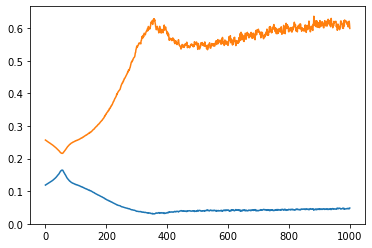

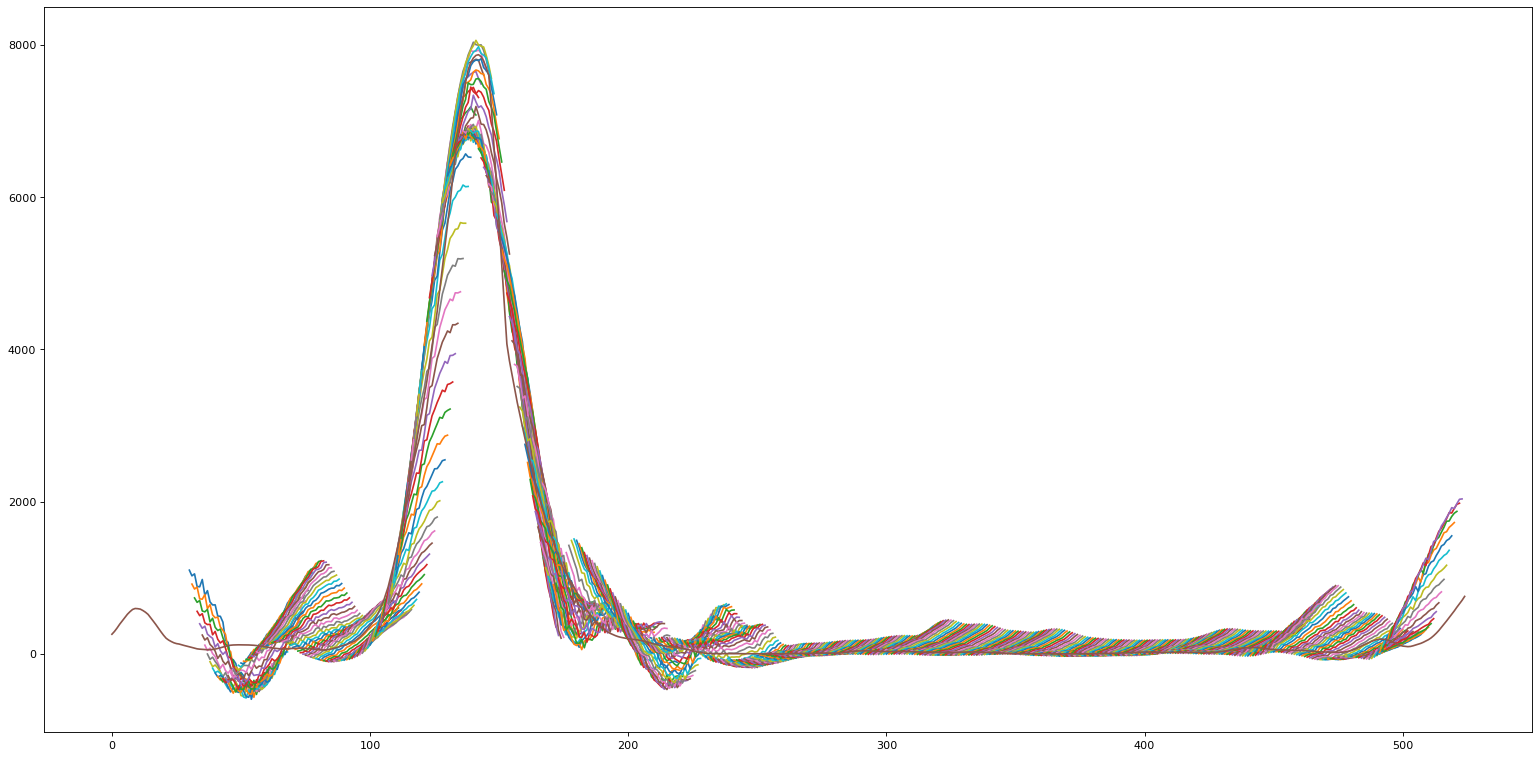

In [137]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1, 32, 7, padding=3), nn.ReLU(),
    nn.Conv1d(32, 32, 5, padding=2), nn.ReLU(),
    nn.Conv1d(32, 32, 3, padding=1), nn.ReLU(),
    nn.Conv1d(32, 32, 3, padding=1), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
])

In [190]:
model = train_and_visualise([
    Lambda(prep_conv),

    nn.Conv1d(1,  32, 15, padding=7), nn.ReLU(),
    nn.Conv1d(32, 32, 13, padding=6), nn.ReLU(),
    nn.Conv1d(32, 32, 11, padding=5), nn.ReLU(),
    nn.Conv1d(32, 32, 9,  padding=4), nn.ReLU(),
    nn.Conv1d(32, 32, 7,  padding=3), nn.ReLU(),
    nn.Conv1d(32, 32, 5,  padding=2), nn.ReLU(),
    nn.Conv1d(32, 32, 3,  padding=1), nn.ReLU(),
    nn.Conv1d(32, 32, 3,  padding=1), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
], epochs=10_000)

TypeError: get_model() missing 1 required positional argument: 'learning_rate'

## Prediction

In [192]:
model, opt = get_model([
    Lambda(prep_conv),

    nn.Conv1d(1,  32, 15, padding=7), nn.ReLU(),
    nn.Conv1d(32, 32, 13, padding=6), nn.ReLU(),
    nn.Conv1d(32, 32, 11, padding=5), nn.ReLU(),
    nn.Conv1d(32, 32, 9,  padding=4), nn.ReLU(),
    nn.Conv1d(32, 32, 7,  padding=3), nn.ReLU(),
    nn.Conv1d(32, 32, 5,  padding=2), nn.ReLU(),
    nn.Conv1d(32, 32, 3,  padding=1), nn.ReLU(),
    nn.Conv1d(32, 32, 3,  padding=1), nn.ReLU(),

    Lambda(flatten),
    nn.Linear(960, 30),
], learning_rate=0.01)

0 tensor(0.1282) tensor(0.0025)
100 tensor(0.1843) tensor(0.0020)
200 tensor(0.1962) tensor(0.0020)
300 tensor(0.0528) tensor(0.0058)
400 tensor(0.0587) tensor(0.0096)
500 tensor(0.1193) tensor(0.0063)
600 tensor(0.1170) tensor(0.0073)
700 tensor(0.0059) tensor(0.0204)
800 tensor(0.0675) tensor(0.0143)
900 tensor(0.1323) tensor(0.0092)
1000 tensor(0.0541) tensor(0.0165)
1100 tensor(0.2490) tensor(0.0034)
1200 tensor(0.2310) tensor(0.0047)
1300 tensor(0.2179) tensor(0.0046)
1400 tensor(0.1624) tensor(0.0072)
1500 tensor(0.1915) tensor(0.0046)
1600 tensor(0.1178) tensor(0.0132)
1700 tensor(0.1808) tensor(0.0052)
1800 tensor(0.1773) tensor(0.0051)
1900 tensor(0.1477) tensor(0.0053)
2000 tensor(0.1535) tensor(0.0052)
2100 tensor(0.1484) tensor(0.0052)
2200 tensor(0.1444) tensor(0.0056)
2300 tensor(0.1380) tensor(0.0055)
2400 tensor(0.1442) tensor(0.0053)
2500 tensor(0.1424) tensor(0.0055)
2600 tensor(0.1546) tensor(0.0052)
2700 tensor(0.1607) tensor(0.0050)
2800 tensor(0.1531) tensor(0.005

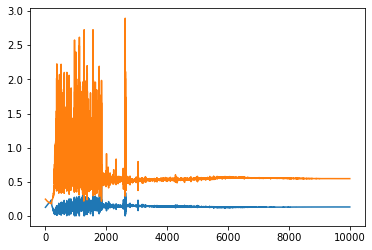

In [193]:
loss, acc = fit(10_000, model, loss_func, opt, train_dl, valid_dl)

In [194]:
def predict(offset):
    if offset > 0:
        x_most_recent = torch.tensor(norm_running_mean[-input_window-offset:-offset]).float()
    else:
        x_most_recent = torch.tensor(norm_running_mean[-input_window:]).float()
    x_most_recent = x_most_recent.unsqueeze(dim=0)
    preds = model(x_most_recent)
    unnorm_preds = preds * std + mean
    unnorm_preds = unnorm_preds.squeeze()
    pred_x = range(len(running_mean)-offset, len(running_mean)+len(unnorm_preds)-offset)
    pred_y = unnorm_preds.tolist()
    
    return pred_x, pred_y

In [195]:
pred_x, pred_y = [], []
for i in range(20):
    px, py = predict(i)
    pred_x.append(px)
    pred_y.append(py)

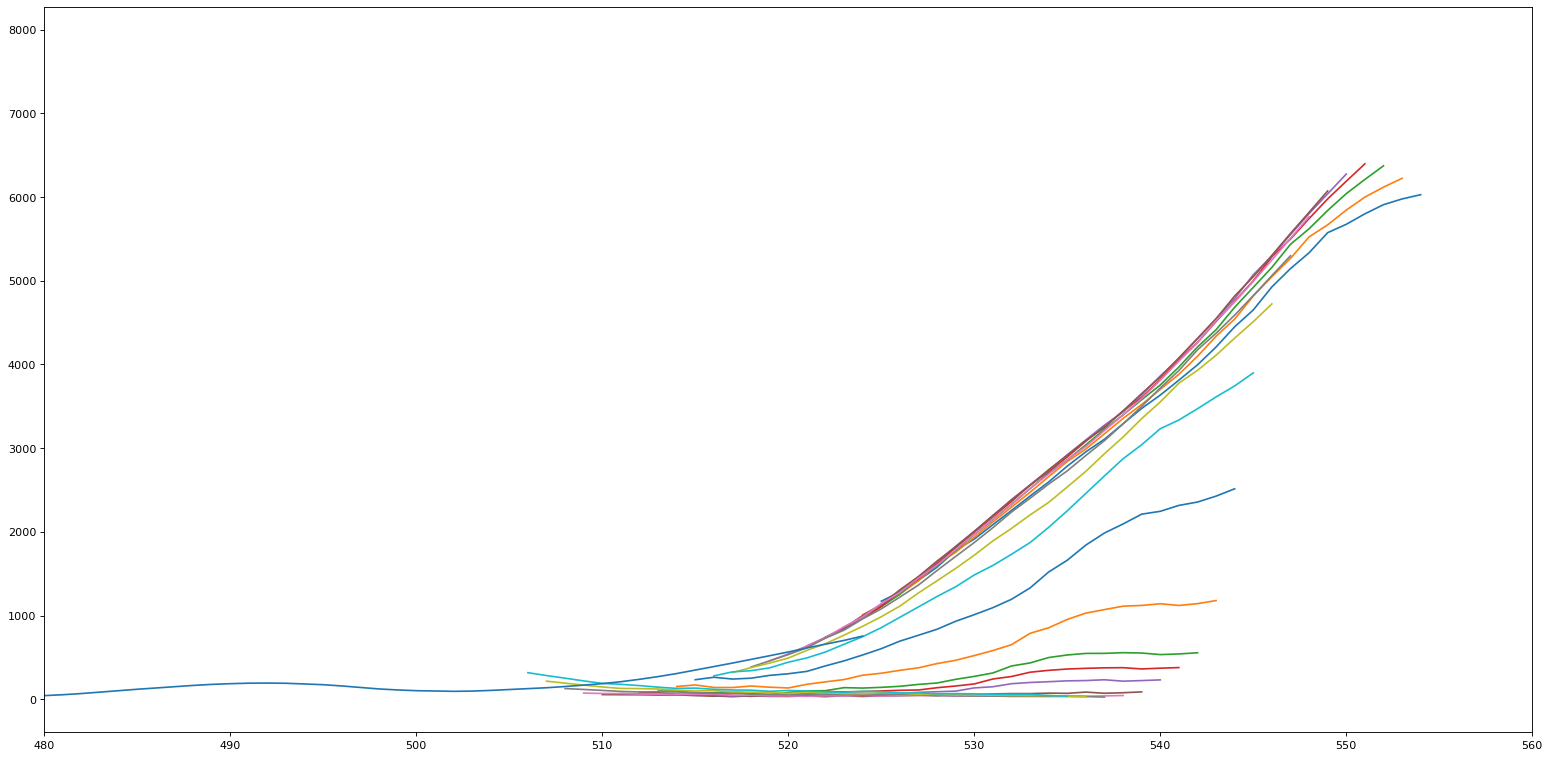

In [196]:
plt.figure(figsize=(24, 12), dpi=80)
for i in range(len(pred_x)):
    plt.plot(pred_x[i], pred_y[i])
plt.plot(running_mean)
plt.xlim([480, 560])
plt.show()

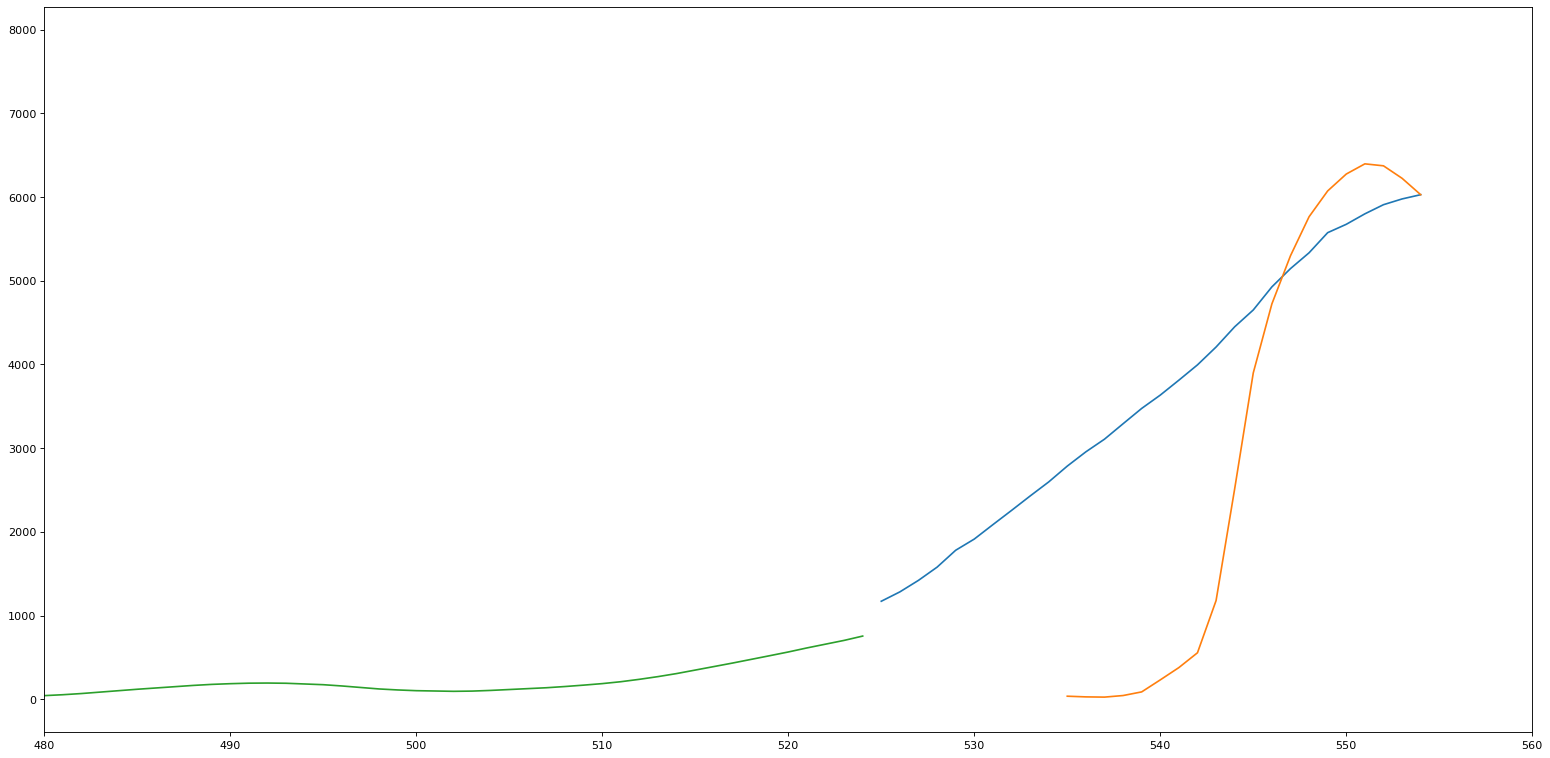

In [197]:
plt.figure(figsize=(24, 12), dpi=80)
plt.plot(pred_x[0], pred_y[0])

far_preds_x = list(map(lambda r: max(r), pred_x))
far_preds_y = list(map(lambda y: y[-1:], pred_y))
plt.plot(far_preds_x, far_preds_y)

plt.plot(running_mean)
plt.xlim([480, 560])
plt.show()

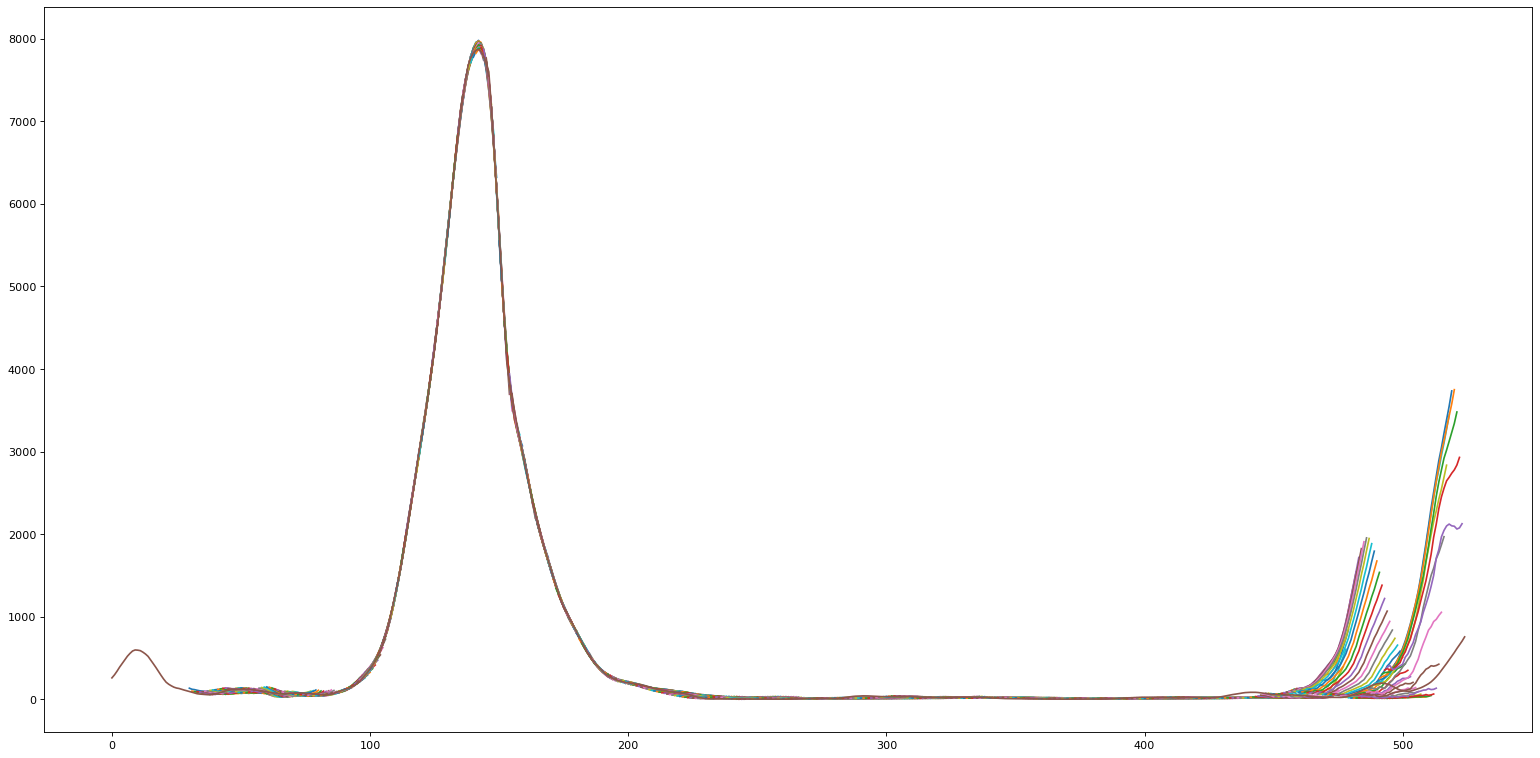

In [199]:
def foo():
    preds = model(torch.tensor(x).float())
    unnorm_preds = preds * std + mean
    plot_results(unnorm_preds)
foo()

Looks like about 5000 epochs was enough to converge
(out of 10k epochs with fit one cycle)

Idea: Show full history with one prediction every 30 days

ie. The equivalent of showing prediction vs result over historical data

## Directions to take this from here

- Automate data fetching etc. and productionalise
- Add more input data types
  - wilds
  - contact tracing stats
  - daily test numbers
- Add input data from other states
- Learn some more best practices and implement them
  - Better optimiser (eg. one-cycle training)
  - Batchnorm / dropout
  - Better loss function (WAPE)
  - Work out optimal training (ie. find point of overfit then prevent)
- Try a longer forecast window

### Given all of that, where might I take it this afternoon?

I reckon getting something shipped would be really helpful.
Much as there's lots of ways I can improve what I'm doing here,
it'll be really helpful to have a nicely presented model to reference against, build off and share.

That's somewhat complicated by the continual training requirements.
Let's peg this arvo to explore how to make that happen.